# (1) ONNX Runtime 使用
#https://github.com/onnx/onnx-docker/tree/master/onnx-ecosystem/inference_demos

In [ ]:
import onnxruntime
session = onnxruntime.InferenceSession('faster_rcnn_R_50_FPN_1x.onnx')

In [8]:
# 安裝相對應版本
!pip install onnx==1.5.0
!pip install onnxruntime==0.4.0
!pip install numpy==1.15.1
!pip install Pillow
!pip install --upgrade Pillow
!pip install onnx-tf

  Using cached onnx-1.5.0-cp36-cp36m-win_amd64.whl (4.1 MB)
  Attempting uninstall: onnx
    Found existing installation: onnx 1.8.0
    Uninstalling onnx-1.8.0:
      Successfully uninstalled onnx-1.8.0


ERROR: winmltools 1.5.1 has requirement numpy==1.16.4, but you'll have numpy 1.19.4 which is incompatible.
ERROR: onnx-tf 1.6.0 has requirement onnx>=1.6.0, but you'll have onnx 1.5.0 which is incompatible.


  Attempting uninstall: onnxruntime
    Found existing installation: onnxruntime 1.6.0
    Uninstalling onnxruntime-1.6.0:
      Successfully uninstalled onnxruntime-1.6.0

ERROR: winmltools 1.5.1 has requirement numpy==1.16.4, but you'll have numpy 1.15.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement numpy<2.0,>=1.16.0, but you'll have numpy 1.15.1 which is incompatible.
ERROR: tensorflow-hub 0.10.0 has requirement protobuf>=3.8.0, but you'll have protobuf 3.6.1 which is incompatible.
ERROR: onnx-tf 1.6.0 has requirement onnx>=1.6.0, but you'll have onnx 1.5.0 which is incompatible.
ERROR: astropy 4.0.1.post1 has requirement numpy>=1.16, but you'll have numpy 1.15.1 which is incompatible.



  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.4
    Uninstalling numpy-1.19.4:
      Successfully uninstalled numpy-1.19.4


In [6]:
import onnx;print('onnx ver',onnx.__version__)
import tensorflow as tf;print('tf ver',tf.__version__)

onnx ver 1.5.0
tf ver 1.15.0


# (2) ONNX Runtime 實際範例 - 物件偵測

In [1]:
#Download faster RCNN ONNX Model
import onnx
import onnxruntime
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import urllib.request     # urllib is a built-in Python library to download files from URLs
%matplotlib inline

onnx_model_url = "https://onnxzoo.blob.core.windows.net/models/opset_10/faster_rcnn/faster_rcnn_R_50_FPN_1x.onnx"
output_classes_url = "https://onnxzoo.blob.core.windows.net/models/opset_10/faster_rcnn/coco_classes.txt"
urllib.request.urlretrieve(onnx_model_url, filename="faster_rcnn_R_50_FPN_1x.onnx")
urllib.request.urlretrieve(output_classes_url, filename="coco_classes.txt")

('coco_classes.txt', <http.client.HTTPMessage at 0x2884c202198>)

In [2]:
#Preprocess 預處理
def preprocess(image):
    # Resize
    ratio = 800.0 / min(image.size[0], image.size[1])
    image = image.resize((int(ratio * image.size[0]), int(ratio * image.size[1])), Image.BILINEAR)

    # Convert to BGR
    image = np.array(image)[:, :, [2, 1, 0]].astype('float32')

    # HWC -> CHW
    image = np.transpose(image, [2, 0, 1])

    # Normalize
    mean_vec = np.array([102.9801, 115.9465, 122.7717])
    for i in range(image.shape[0]):
        image[i, :, :] = image[i, :, :] - mean_vec[i]

    # Pad to be divisible of 32
    import math
    padded_h = int(math.ceil(image.shape[1] / 32) * 32)
    padded_w = int(math.ceil(image.shape[2] / 32) * 32)

    padded_image = np.zeros((3, padded_h, padded_w), dtype=np.float32)
    padded_image[:, :image.shape[1], :image.shape[2]] = image
    image = padded_image
    
    return image

def display_objdetect_image(image, boxes, labels, scores, score_threshold=0.7):
    # Resize boxes
    ratio = 800.0 / min(image.size[0], image.size[1])
    boxes = boxes / ratio

    _, ax = plt.subplots(1, figsize=(12,9))
    ax.imshow(image)

    # Showing boxes with score > 0.7
    for box, label, score in zip(boxes, labels, scores):
        if score > score_threshold:
            rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],\
                                     linewidth=1, edgecolor='b',facecolor='none')
            ax.annotate(classes[label] + ':' + str(np.round(score, 2)), (box[0], box[1]),\
                        color='w', fontsize=12)
            ax.add_patch(rect)
    plt.show()

5.682343006134033
Boxes: (77, 4)
Labels: (77,)
Scores: (77,)


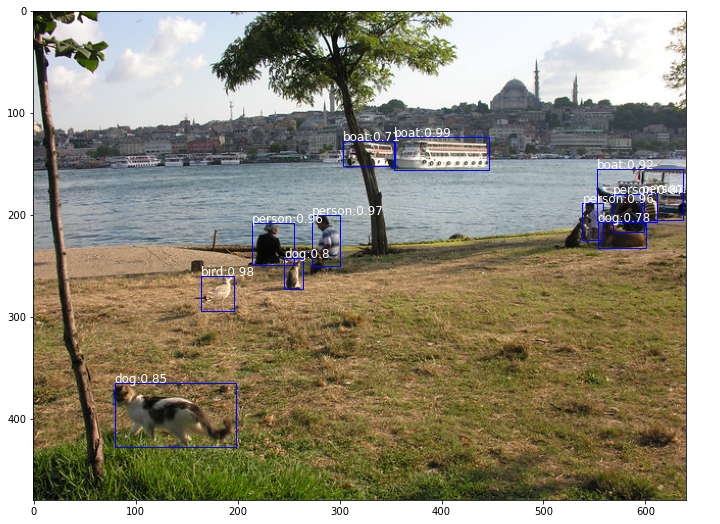

In [3]:
import time
start = time.time()

#載入標籤
classes = [line.rstrip('\n') for line in open('coco_classes.txt')]

#使用 onnxruntime 載入模組
session = onnxruntime.InferenceSession('faster_rcnn_R_50_FPN_1x.onnx')

#載入影像
img = Image.open('frcnn_demo.jpg')
img_data = preprocess(img)

#開始預測
boxes, labels, scores = session.run(None, {session.get_inputs()[0].name: img_data});end = time.time()
print(end-start)
print('Boxes:', boxes.shape);print('Labels:', labels.shape);print('Scores:', scores.shape)

#顯示結果 & 標示
display_objdetect_image(img, boxes, labels, scores)

# (3) 將模組轉換 ONNX 格式
https://d246810g2000.medium.com/nvidia-jetson-nano-for-jetpack-4-4-03-%E8%BD%89%E6%8F%9B%E5%90%84%E7%A8%AE%E6%A8%A1%E5%9E%8B%E6%A1%86%E6%9E%B6%E5%88%B0-onnx-%E6%A8%A1%E5%9E%8B-17adcece9c34

In [ ]:
!pip install requirements.txt

In [49]:
#(1) keras to onnx
import onnxmltools
from keras.models import load_model
input_keras_model = "CNN_Keras.h5"
output_onnx_model = "CNN_Keras.onnx"
keras_model = load_model(input_keras_model)
onnx_model  = onnxmltools.convert_keras(keras_model) #convert onnx
onnxmltools.utils.save_model(onnx_model, output_onnx_model)
print(output_onnx_model, 'transfered done')

In [1]:
#(2) caffe to onnx
!pip install -U coremltools onnxmltools
import onnx
import coremltools
import onnxmltools
caffe_path = "alexnet.caffemodel" #須下載
proto_path = "train_val.prototxt"
coreml_model = coremltools.converters.caffe.convert((caffe_path, proto_path)) 
onnx_model = onnxmltools.convert_coreml(coreml_model)
onnxmltools.utils.save_model(onnx_model, output_onnx_model)

Requirement already up-to-date: onnxmltools in d:\programdata\anaconda3\envs\tensorflow\lib\site-packages (1.7.0)
  Created wheel for coremltools: filename=coremltools-4.1-py3-none-any.whl size=1038605 sha256=4dad47170b3d9455bfc21623671cff302e7dcb810095040c480180a08a2177bd
  Stored in directory: c:\users\fre5x\appdata\local\pip\cache\wheels\a4\f5\15\285d6b0b8dd75c8027afe6ecd8cd405f6f7c6c6053198cf379
Successfully built coremltools
  Attempting uninstall: coremltools
    Found existing installation: coremltools 4.0
    Uninstalling coremltools-4.0:
      Successfully uninstalled coremltools-4.0


ImportError: cannot import name 'libcaffeconverter'

In [10]:
import torch
torch.hub.download_url_to_file('https://s3.amazonaws.com/pytorch/models/resnet18-5c106cde.pth', 'resnet18-5c106cde.pth')

In [9]:
#(3)PyTorch to onnx - 1
!pip install -U torchvision
from torch.autograd import Variable
import torch.onnx
import torchvision
input_pytorch_model = 'resnet18-5c106cde.pth'
output_onnx_model = 'resnet18-5c106cde.onnx'
dummy_model_input = Variable(torch.randn(1, 3, 224, 224, device='cpu'))
model = torch.load(input_pytorch_model,map_location='cpu')
#torch.onnx.export(model, dummy_model_input, output_onnx_model)#need look  pth format

ERROR: Could not find a version that satisfies the requirement torch==1.4.0 (from torchvision) (from versions: 0.1.2, 0.1.2.post1, 0.1.2.post2, 1.7.0, 1.7.1)
ERROR: No matching distribution found for torch==1.4.0 (from torchvision)


  Using cached torchvision-0.5.0-cp36-cp36m-win_amd64.whl (1.2 MB)


In [154]:
#(3) pyTorch to onnx - 2
import torch.onnx
import torchvision
dummy_input = torch.randn(1, 3, 224, 224)
model = torchvision.models.alexnet(pretrained=True)#'***.pth'
torch.onnx.export(model, dummy_input, "alexnet_pytorch.onnx")

In [22]:
#(4) microsoft cntk to onnx
!pip install cntk==2.6
import cntk as C
input_cntk_model = 'InceptionV3_ImageNet_CNTK.model'
output_onnx_model = 'InceptionV3_ImageNet_CNTK.onnx'
cntk_model = C.Function.load(input_cntk_model, device=C.device.cpu()) #loaing
cntk_model.save(output_onnx_model, format=C.ModelFormat.ONNX)
print(output_onnx_model, 'transfered done')

In [50]:
#(5) mxnet to onnx
import mxnet as mx
import numpy as np
from mxnet.contrib import onnx as onnx_mxnet
input_mxnet_symbol = 'LeNet-symbol.json'
input_mxnet_params = 'LeNet-0005.params'
input_shape = (1,1,28,28)
output_onnx_model = 'LeNet-symbol_MXnet.onnx'
onnx_mxnet.export_model(input_mxnet_symbol, input_mxnet_params, [input_shape], np.float32, output_onnx_model)
print(output_onnx_model, 'transfered done')

In [142]:
#(6) Sk-learn
# Train a model.
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
clr = RandomForestClassifier()
clr.fit(X_train, y_train)

# Convert into ONNX format
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
initial_type = [('float_input', FloatTensorType([None, 4]))]
onx = convert_sklearn(clr, initial_types=initial_type)
with open("rf_iris_sklearn.onnx", "wb") as f:
    f.write(onx.SerializeToString())

In [88]:
#(7) coreml to onnx
import coremltools
import onnxmltools
input_coreml_model = 'MobileNet_CoreML.mlmodel'
output_onnx_model = 'MobileNet_CoreML.onnx'
coreml_model = coremltools.utils.load_spec(input_coreml_model)
onnx_model = onnxmltools.convert_coreml(coreml_model)
onnxmltools.utils.save_model(onnx_model, output_onnx_model)

In [83]:
#(8) tf to onnx
!python -m tf2onnx.convert --input CNNmodel.pb --inputs x:0 --outputs prediction:0 --output CNNmodel.onnx --verbose

In [85]:
#(9)* tflite to onnx
!pip install tflite2onnx
import tflite2onnx
tflite_path = "CNN_model1.tflite"
onnx_path = "CNN_model_tflite.onxx"
#tflite2onnx.convert(tflite_path, onnx_path)

In [107]:
#(10) lightgbm to onnx
!pip install lightgbm
import lightgbm as lgb
import onnxmltools
input_lgb_model = 'iris_model_lightGBM.txt' 
output_onnx_model = 'iris_model_lightGBM.onnx'
lgb_model = lgb.Booster(model_file=input_lgb_model)
lgb_model
#onnx_model = onnxmltools.convert_lightgbm(lgb_model, initial_types=[(variable_name, data_type), (variable_name, data_type)])
#onnxmltools.utils.save_model(onnx_model, output_onnx_model)

In [108]:
#(10-1) Using lightgbm getting model
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
# 加载数据
iris = load_iris()
data = iris.data
target = iris.target

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)
print("Train data length:", len(X_train))
print("Test data length:", len(X_test))

# 转换为Dataset数据格式
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# 参数
params = {
    'task': 'train',
    'boosting_type': 'gbdt',  # 设置提升类型
    'objective': 'regression',  # 目标函数
    'metric': {'l2', 'auc'},  # 评估函数
    'num_leaves': 31,  # 叶子节点数
    'learning_rate': 0.05,  # 学习速率
    'feature_fraction': 0.9,  # 建树的特征选择比例
    'bagging_fraction': 0.8,  # 建树的样本采样比例
    'bagging_freq': 5,  # k 意味着每 k 次迭代执行bagging
    'verbose': 1  # <0 显示致命的, =0 显示错误 (警告), >0 显示信息
}

# 模型训练
gbm = lgb.train(params, lgb_train, num_boost_round=20, valid_sets=lgb_eval, early_stopping_rounds=5)

# 模型保存
gbm.save_model('iris_model_lightGBM.txt')

# 模型加载
gbm = lgb.Booster(model_file='iris_model_lightGBM.txt')

# 模型预测
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

# 模型评估
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
print('best_iteration:',gbm.best_iteration)

# (4) 將 ONNX 格式轉換成其他模組格式

In [10]:
#(1) onnx to tensorflow
!pip install onnx-tf==1.1
import onnx
from onnx_tf.backend import prepare
onnx_model = onnx.load("resnet50-caffe2-v1-3.onnx")
tf_rep = prepare(onnx_model)
tf_rep.export_graph("resnet50-caffe2-v1-3.pb")

In [46]:
#(2) onnx to coreml
!pip install onnx-coreml==0.04
import sys
from onnx import onnx_pb
from onnx_coreml import convert
model_file = open('super_resolution.onnx', 'rb')
model_proto = onnx_pb.ModelProto()
model_proto.ParseFromString(model_file.read())
coreml_model = convert(model_proto, image_input_names=['1'], image_output_names=['27'])
coreml_model.save('super_resolution_onnx2coreml.mlmodel')

In [39]:
#(3) onnx to caffe2
import torch
import torchvision
dummy_input = torch.randn(10, 3, 224, 224, device='cpu')
model = torchvision.models.alexnet(pretrained=True).cpu()
input_names = [ "actual_input_1" ] + [ "learned_%d" % i for i in range(16) ]
output_names = [ "output1" ]
torch.onnx.export(model, dummy_input, "alexnet_caffe.onnx", verbose=True, input_names=input_names, output_names=output_names)

In [3]:
!pip install onnx-caffe2==1.0.0
#https://wizardforcel.gitbooks.io/pytorch-03-doc/content/super_resolution_with_caffe2.html
import onnx
import onnx_caffe2.backend
model = onnx.load("alexnet_caffe.onnx")
onnx.checker.check_model(model)
prepared_backend = onnx_caffe2.backend.prepare(model)

from caffe2.python.predictor import mobile_exporter
c2_workspace = prepared_backend.workspace
c2_model = prepared_backend.predict_net
init_net, predict_net = mobile_exporter.Export(c2_workspace, c2_model, c2_model.external_input)
with open('init_net.pb', "wb") as fopen:
    fopen.write(init_net.SerializeToString())
with open('predict_net.pb', "wb") as fopen:
    fopen.write(predict_net.SerializeToString())

ValidationError: Your model ir_version is higher than the checker's.

In [4]:
#(4) onnx to keras
!pip install onnx2keras==0.0.20
import onnx
from onnx2keras import onnx_to_keras
onnx_model = onnx.load('mobilenetv2-7.onnx')
k_model = onnx_to_keras(onnx_model, ['data'])
#keras.models.save_model(k_model,'mobilenetv2-7_kerastoTensorflow.h5')

INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:None
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> data.
DEBUG:onnx2keras:Input 1 -> mobilenetv20_features_conv0_weight.
DEBUG:onnx2keras:Input 2 -> mobilenetv20_features_batchnorm0_gamma.
DEBUG:onnx2keras:Input 3 -> mobilenetv20_features_batchnorm0_beta.
DEBUG:onnx2keras:Input 4 -> mobilenetv20_features_batchnorm0_running_mean.
DEBUG:onnx2keras:Input 5 -> mobilenetv20_features_batchnorm0_running_var.
DEBUG:onnx2keras:Input 6 -> mobilenetv20_features_linearbottleneck0_conv0_weight.
DEBUG:onnx2keras:Input 7 -> mobilenetv20_features_linearbottleneck0_batchnorm0_gamma.
DEBUG:onnx2keras:Input 8 -> mobilenetv20_features_linearbottleneck0_batchnorm0_beta.
DEBUG:onnx2keras:Input 9 -> mobilenetv20_features_linearbottleneck0_batchnorm0_running_mean.
DEBUG:onnx2keras:Input 10 -> mobilenetv20_features_linearbottleneck0_batchnorm0_running_var.
DEBUG:onnx2keras:Input 11 -> mobilenetv20_features_lin

DEBUG:onnx2keras:Input 93 -> mobilenetv20_features_linearbottleneck5_batchnorm2_beta.
DEBUG:onnx2keras:Input 94 -> mobilenetv20_features_linearbottleneck5_batchnorm2_running_mean.
DEBUG:onnx2keras:Input 95 -> mobilenetv20_features_linearbottleneck5_batchnorm2_running_var.
DEBUG:onnx2keras:Input 96 -> mobilenetv20_features_linearbottleneck6_conv0_weight.
DEBUG:onnx2keras:Input 97 -> mobilenetv20_features_linearbottleneck6_batchnorm0_gamma.


DEBUG:onnx2keras:Input 98 -> mobilenetv20_features_linearbottleneck6_batchnorm0_beta.
DEBUG:onnx2keras:Input 99 -> mobilenetv20_features_linearbottleneck6_batchnorm0_running_mean.
DEBUG:onnx2keras:Input 100 -> mobilenetv20_features_linearbottleneck6_batchnorm0_running_var.
DEBUG:onnx2keras:Input 101 -> mobilenetv20_features_linearbottleneck6_conv1_weight.
DEBUG:onnx2keras:Input 102 -> mobilenetv20_features_linearbottleneck6_batchnorm1_gamma.
DEBUG:onnx2keras:Input 103 -> mobilenetv20_features_linearbottleneck6_batchnorm1_beta.
DEBUG:onnx2keras:Input 104 -> mobilenetv20_features_linearbottleneck6_batchnorm1_running_mean.
DEBUG:onnx2keras:Input 105 -> mobilenetv20_features_linearbottleneck6_batchnorm1_running_var.
DEBUG:onnx2keras:Input 106 -> mobilenetv20_features_linearbottleneck6_conv2_weight.
DEBUG:onnx2keras:Input 107 -> mobilenetv20_features_linearbottleneck6_batchnorm2_gamma.
DEBUG:onnx2keras:Input 108 -> mobilenetv20_features_linearbottleneck6_batchnorm2_beta.
DEBUG:onnx2keras:In

DEBUG:onnx2keras:Input 190 -> mobilenetv20_features_linearbottleneck12_batchnorm0_running_var.
DEBUG:onnx2keras:Input 191 -> mobilenetv20_features_linearbottleneck12_conv1_weight.
DEBUG:onnx2keras:Input 192 -> mobilenetv20_features_linearbottleneck12_batchnorm1_gamma.
DEBUG:onnx2keras:Input 193 -> mobilenetv20_features_linearbottleneck12_batchnorm1_beta.
DEBUG:onnx2keras:Input 194 -> mobilenetv20_features_linearbottleneck12_batchnorm1_running_mean.
DEBUG:onnx2keras:Input 195 -> mobilenetv20_features_linearbottleneck12_batchnorm1_running_var.
DEBUG:onnx2keras:Input 196 -> mobilenetv20_features_linearbottleneck12_conv2_weight.
DEBUG:onnx2keras:Input 197 -> mobilenetv20_features_linearbottleneck12_batchnorm2_gamma.
DEBUG:onnx2keras:Input 198 -> mobilenetv20_features_linearbottleneck12_batchnorm2_beta.
DEBUG:onnx2keras:Input 199 -> mobilenetv20_features_linearbottleneck12_batchnorm2_running_mean.
DEBUG:onnx2keras:Input 200 -> mobilenetv20_features_linearbottleneck12_batchnorm2_running_var.

DEBUG:onnx2keras:Found weight mobilenetv20_features_linearbottleneck0_batchnorm1_beta with shape (32,).
DEBUG:onnx2keras:Found weight mobilenetv20_features_linearbottleneck0_batchnorm1_running_mean with shape (32,).
DEBUG:onnx2keras:Found weight mobilenetv20_features_linearbottleneck0_batchnorm1_running_var with shape (32,).
DEBUG:onnx2keras:Found weight mobilenetv20_features_linearbottleneck0_conv2_weight with shape (16, 32, 1, 1).
DEBUG:onnx2keras:Found weight mobilenetv20_features_linearbottleneck0_batchnorm2_gamma with shape (16,).
DEBUG:onnx2keras:Found weight mobilenetv20_features_linearbottleneck0_batchnorm2_beta with shape (16,).
DEBUG:onnx2keras:Found weight mobilenetv20_features_linearbottleneck0_batchnorm2_running_mean with shape (16,).
DEBUG:onnx2keras:Found weight mobilenetv20_features_linearbottleneck0_batchnorm2_running_var with shape (16,).
DEBUG:onnx2keras:Found weight mobilenetv20_features_linearbottleneck1_conv0_weight with shape (96, 16, 1, 1).
DEBUG:onnx2keras:Foun

DEBUG:onnx2keras:Found weight mobilenetv20_features_linearbottleneck10_batchnorm1_running_mean with shape (384,).
DEBUG:onnx2keras:Found weight mobilenetv20_features_linearbottleneck10_batchnorm1_running_var with shape (384,).
DEBUG:onnx2keras:Found weight mobilenetv20_features_linearbottleneck10_conv2_weight with shape (96, 384, 1, 1).
DEBUG:onnx2keras:Found weight mobilenetv20_features_linearbottleneck10_batchnorm2_gamma with shape (96,).
DEBUG:onnx2keras:Found weight mobilenetv20_features_linearbottleneck10_batchnorm2_beta with shape (96,).
DEBUG:onnx2keras:Found weight mobilenetv20_features_linearbottleneck10_batchnorm2_running_mean with shape (96,).
DEBUG:onnx2keras:Found weight mobilenetv20_features_linearbottleneck10_batchnorm2_running_var with shape (96,).
DEBUG:onnx2keras:Found weight mobilenetv20_features_linearbottleneck11_conv0_weight with shape (576, 96, 1, 1).
DEBUG:onnx2keras:Found weight mobilenetv20_features_linearbottleneck11_batchnorm0_gamma with shape (576,).
DEBUG:

DEBUG:onnx2keras:Found weight mobilenetv20_features_linearbottleneck15_batchnorm1_running_mean with shape (960,).
DEBUG:onnx2keras:Found weight mobilenetv20_features_linearbottleneck15_batchnorm1_running_var with shape (960,).
DEBUG:onnx2keras:Found weight mobilenetv20_features_linearbottleneck15_conv2_weight with shape (160, 960, 1, 1).
DEBUG:onnx2keras:Found weight mobilenetv20_features_linearbottleneck15_batchnorm2_gamma with shape (160,).
DEBUG:onnx2keras:Found weight mobilenetv20_features_linearbottleneck15_batchnorm2_beta with shape (160,).
DEBUG:onnx2keras:Found weight mobilenetv20_features_linearbottleneck15_batchnorm2_running_mean with shape (160,).
DEBUG:onnx2keras:Found weight mobilenetv20_features_linearbottleneck15_batchnorm2_running_var with shape (160,).
DEBUG:onnx2keras:Found weight mobilenetv20_features_linearbottleneck16_conv0_weight with shape (960, 160, 1, 1).
DEBUG:onnx2keras:Found weight mobilenetv20_features_linearbottleneck16_batchnorm0_gamma with shape (960,).


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: BatchNormalization
DEBUG:onnx2keras:node_name: mobilenetv20_features_batchnorm0_fwd
DEBUG:onnx2keras:node_params: {'epsilon': 9.999999747378752e-06, 'momentum': 0.8999999761581421, 'spatial': 1, 'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name mobilenetv20_features_conv0_fwd).
DEBUG:onnx2keras:Check input 1 (name mobilenetv20_features_batchnorm0_gamma).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:Check input 2 (name mobilenetv20_features_batchnorm0_beta).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:Chec

DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name mobilenetv20_features_linearbottleneck0_relu1_fwd).
DEBUG:onnx2keras:Check input 1 (name mobilenetv20_features_linearbottleneck0_conv2_weight).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:conv:Conv without bias
DEBUG:onnx2keras:conv:2D convolution
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: BatchNormalization
DEBUG:onnx2keras:node_name: mobilenetv20_features_linearbottleneck0_batchnorm2_fwd
DEBUG:onnx2keras:node_params: {'epsilon': 9.999999747378752e-06, 'momentum': 0.8999999761581421, 'spatial': 1, 'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name mobilenetv20_features_li

DEBUG:onnx2keras:Check input 1 (name mobilenetv20_features_linearbottleneck1_conv2_weight).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:conv:Conv without bias
DEBUG:onnx2keras:conv:2D convolution
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: BatchNormalization
DEBUG:onnx2keras:node_name: mobilenetv20_features_linearbottleneck1_batchnorm2_fwd
DEBUG:onnx2keras:node_params: {'epsilon': 9.999999747378752e-06, 'momentum': 0.8999999761581421, 'spatial': 1, 'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name mobilenetv20_features_linearbottleneck1_conv2_fwd).
DEBUG:onnx2keras:Check input 1 (name mobilenetv20_features_linearbottleneck1_batchnorm2_gamma).
DEBUG:onnx2keras:The input not found i

DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:conv:Conv without bias
DEBUG:onnx2keras:conv:2D convolution
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: BatchNormalization
DEBUG:onnx2keras:node_name: mobilenetv20_features_linearbottleneck2_batchnorm2_fwd
DEBUG:onnx2keras:node_params: {'epsilon': 9.999999747378752e-06, 'momentum': 0.8999999761581421, 'spatial': 1, 'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name mobilenetv20_features_linearbottleneck2_conv2_fwd).
DEBUG:onnx2keras:Check input 1 (name mobilenetv20_features_linearbottleneck2_batchnorm2_gamma).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:o

DEBUG:onnx2keras:type: Conv
DEBUG:onnx2keras:node_name: mobilenetv20_features_linearbottleneck3_conv2_fwd
DEBUG:onnx2keras:node_params: {'dilations': [1, 1], 'group': 1, 'kernel_shape': [1, 1], 'pads': [0, 0, 0, 0], 'strides': [1, 1], 'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name mobilenetv20_features_linearbottleneck3_relu1_fwd).
DEBUG:onnx2keras:Check input 1 (name mobilenetv20_features_linearbottleneck3_conv2_weight).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:conv:Conv without bias
DEBUG:onnx2keras:conv:2D convolution
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: BatchNormalization
DEBUG:onnx2keras:node_name: mobilenetv20_features_linearbottleneck3_batchnorm2_fwd
DEBUG:onnx

DEBUG:onnx2keras:node_params: {'dilations': [1, 1], 'group': 1, 'kernel_shape': [1, 1], 'pads': [0, 0, 0, 0], 'strides': [1, 1], 'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name mobilenetv20_features_linearbottleneck4_relu1_fwd).
DEBUG:onnx2keras:Check input 1 (name mobilenetv20_features_linearbottleneck4_conv2_weight).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:conv:Conv without bias
DEBUG:onnx2keras:conv:2D convolution
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: BatchNormalization
DEBUG:onnx2keras:node_name: mobilenetv20_features_linearbottleneck4_batchnorm2_fwd
DEBUG:onnx2keras:node_params: {'epsilon': 9.999999747378752e-06, 'momentum': 0.8999999761581421, 'spatial': 1, 'chan

DEBUG:onnx2keras:node_params: {'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name mobilenetv20_features_linearbottleneck5_batchnorm1_fwd).
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Conv
DEBUG:onnx2keras:node_name: mobilenetv20_features_linearbottleneck5_conv2_fwd
DEBUG:onnx2keras:node_params: {'dilations': [1, 1], 'group': 1, 'kernel_shape': [1, 1], 'pads': [0, 0, 0, 0], 'strides': [1, 1], 'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name mobilenetv20_features_linearbottleneck5_relu1_fwd).
DEBUG:onnx2keras:Check input 1 (name mobilenetv20_features_linearbottleneck5_conv2_weight).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in w

DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:Check input 4 (name mobilenetv20_features_linearbottleneck6_batchnorm1_running_var).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Relu
DEBUG:onnx2keras:node_name: mobilenetv20_features_linearbottleneck6_relu1_fwd
DEBUG:onnx2keras:node_params: {'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name mobilenetv20_features_linearbottleneck6_batchnorm1_fwd).
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Conv
DEBUG:onnx2keras:node_name: mobilenetv20_features_linearbottleneck6_conv2_fwd


DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Relu
DEBUG:onnx2keras:node_name: mobilenetv20_features_linearbottleneck7_relu1_fwd
DEBUG:onnx2keras:node_params: {'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name mobilenetv20_features_linearbottleneck7_batchnorm1_fwd).
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Conv
DEBUG:onnx2keras:node_name: mobilenetv20_features_linearbottleneck7_conv2_fwd
DEBUG:onnx2keras:node_params: {'dilations': [1, 1], 'group': 1, 'kernel_shape': [1, 1], 'pads': [0, 0, 0, 0], 'strides': [1, 1], 'change_ordering': False, 'name_p

DEBUG:onnx2keras:Check input 2 (name mobilenetv20_features_linearbottleneck8_batchnorm1_beta).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:Check input 3 (name mobilenetv20_features_linearbottleneck8_batchnorm1_running_mean).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:Check input 4 (name mobilenetv20_features_linearbottleneck8_batchnorm1_running_var).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Relu
DEBUG:onnx2keras:node_name: mobilenetv20_features_linearbottleneck8_relu1_fwd
DEBUG:onnx2keras:node_params: {'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:.

DEBUG:onnx2keras:node_params: {'epsilon': 9.999999747378752e-06, 'momentum': 0.8999999761581421, 'spatial': 1, 'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name mobilenetv20_features_linearbottleneck9_conv1_fwd).
DEBUG:onnx2keras:Check input 1 (name mobilenetv20_features_linearbottleneck9_batchnorm1_gamma).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:Check input 2 (name mobilenetv20_features_linearbottleneck9_batchnorm1_beta).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:Check input 3 (name mobilenetv20_features_linearbottleneck9_batchnorm1_running_mean).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:

DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:conv:Conv without bias
DEBUG:onnx2keras:conv:2D convolution
DEBUG:onnx2keras:conv:Paddings exist, add ZeroPadding layer
DEBUG:onnx2keras:conv:Number of groups is equal to input channels, use DepthWise convolution
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: BatchNormalization
DEBUG:onnx2keras:node_name: mobilenetv20_features_linearbottleneck10_batchnorm1_fwd
DEBUG:onnx2keras:node_params: {'epsilon': 9.999999747378752e-06, 'momentum': 0.8999999761581421, 'spatial': 1, 'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name mobilenetv20_features_linearbottleneck10_conv1_fwd).
DEBUG:onnx2keras:Check input 1 (name mobilenetv20_features_linearbottleneck10_batchnorm1_gamma).
DEBUG:onnx2keras:The input not found 

DEBUG:onnx2keras:conv:Conv without bias
DEBUG:onnx2keras:conv:2D convolution
DEBUG:onnx2keras:conv:Paddings exist, add ZeroPadding layer
DEBUG:onnx2keras:conv:Number of groups is equal to input channels, use DepthWise convolution
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: BatchNormalization
DEBUG:onnx2keras:node_name: mobilenetv20_features_linearbottleneck11_batchnorm1_fwd
DEBUG:onnx2keras:node_params: {'epsilon': 9.999999747378752e-06, 'momentum': 0.8999999761581421, 'spatial': 1, 'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name mobilenetv20_features_linearbottleneck11_conv1_fwd).
DEBUG:onnx2keras:Check input 1 (name mobilenetv20_features_linearbottleneck11_batchnorm1_gamma).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2kera

DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name mobilenetv20_features_linearbottleneck12_relu0_fwd).
DEBUG:onnx2keras:Check input 1 (name mobilenetv20_features_linearbottleneck12_conv1_weight).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:conv:Conv without bias
DEBUG:onnx2keras:conv:2D convolution
DEBUG:onnx2keras:conv:Paddings exist, add ZeroPadding layer
DEBUG:onnx2keras:conv:Number of groups is equal to input channels, use DepthWise convolution
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: BatchNormalization
DEBUG:onnx2keras:node_name: mobilenetv20_features_linearbottleneck12_batchnorm1_fwd
DEBUG:onnx2keras:node_params: {'epsilon': 9.999999747378752e-06, 'momentum': 0.8999999761581421, 'spatial': 1, 'change_ordering': False,

DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name mobilenetv20_features_linearbottleneck13_batchnorm0_fwd).
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Conv
DEBUG:onnx2keras:node_name: mobilenetv20_features_linearbottleneck13_conv1_fwd
DEBUG:onnx2keras:node_params: {'dilations': [1, 1], 'group': 576, 'kernel_shape': [3, 3], 'pads': [1, 1, 1, 1], 'strides': [2, 2], 'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name mobilenetv20_features_linearbottleneck13_relu0_fwd).
DEBUG:onnx2keras:Check input 1 (name mobilenetv20_features_linearbottleneck13_conv1_weight).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:... found all, continu

DEBUG:onnx2keras:Check input 0 (name mobilenetv20_features_linearbottleneck14_batchnorm0_fwd).
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Conv
DEBUG:onnx2keras:node_name: mobilenetv20_features_linearbottleneck14_conv1_fwd
DEBUG:onnx2keras:node_params: {'dilations': [1, 1], 'group': 960, 'kernel_shape': [3, 3], 'pads': [1, 1, 1, 1], 'strides': [1, 1], 'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name mobilenetv20_features_linearbottleneck14_relu0_fwd).
DEBUG:onnx2keras:Check input 1 (name mobilenetv20_features_linearbottleneck14_conv1_weight).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:conv:Conv without bias
DEBUG:onnx2keras:conv:2D convol

DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Relu
DEBUG:onnx2keras:node_name: mobilenetv20_features_linearbottleneck15_relu0_fwd
DEBUG:onnx2keras:node_params: {'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name mobilenetv20_features_linearbottleneck15_batchnorm0_fwd).
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Conv
DEBUG:onnx2keras:node_name: mobilenetv20_features_linearbottleneck15_conv1_fwd
DEBUG:onnx2keras:node_params: {'dilations': [1, 1], 'group': 960, 'kernel_shape': [3, 3], 'pads': [1, 1, 1, 1], 'strides': [1, 1], 'change_ordering': False, 'n

DEBUG:onnx2keras:Check input 2 (name mobilenetv20_features_linearbottleneck16_batchnorm0_beta).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:Check input 3 (name mobilenetv20_features_linearbottleneck16_batchnorm0_running_mean).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:Check input 4 (name mobilenetv20_features_linearbottleneck16_batchnorm0_running_var).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Relu
DEBUG:onnx2keras:node_name: mobilenetv20_features_linearbottleneck16_relu0_fwd
DEBUG:onnx2keras:node_params: {'change_ordering': False, 'name_policy': None}
DEBUG:onnx2ker

DEBUG:onnx2keras:Check input 3 (name mobilenetv20_features_batchnorm1_running_mean).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:Check input 4 (name mobilenetv20_features_batchnorm1_running_var).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Relu
DEBUG:onnx2keras:node_name: mobilenetv20_features_relu1_fwd
DEBUG:onnx2keras:node_params: {'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name mobilenetv20_features_batchnorm1_fwd).
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2k

### Windows ML for MicroSoft

In [3]:
#使用 Windows ML tools & CoreMl tool(ios) 讀取模組
from coremltools.models.utils import load_spec
model_coreml = load_spec('MobileNet.mlmodel')
#model_coreml.description

#使用 winmltool 將 mlmodel 轉換成 onnx
from winmltools import convert_coreml
print(help(convert_coreml))

# (5) ONNX Using Load / Save / Optimize

In [16]:
#載入 onnx 模型
import onnx
onnx_model = onnx.load('faster_rcnn_R_50_FPN_1x.onnx')
onnx.checker.check_model(onnx_model)
#onnx.save(onnx_model, 'faster_rcnn_R_50_FPN_1x_New.onnx')

In [6]:
#載入 onnx 模型
import onnx
from onnx import optimizer
onnx_model = onnx.load('faster_rcnn_R_50_FPN_1x.onnx')
onnx.checker.check_model(onnx_model)

#進行優化
optimized_model = optimizer.optimize(onnx_model)
onnx.save(optimized_model, 'faster_rcnn_R_50_FPN_1x_New.onnx')

In [21]:
#
#https://zhuanlan.zhihu.com/p/41255090
import numpy
import onnx
from onnx import numpy_helper

#load and save ONNX model
numpy_array = numpy.array([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]], dtype=float)
tensor = numpy_helper.from_array(numpy_array)# Convert the Numpy array to a TensorProto
new_array = numpy_helper.to_array(tensor)
#save to pb
with open('tensor.pb', 'wb') as f:
    f.write(tensor.SerializeToString())
    
#Load model(pb)
new_tensor = onnx.TensorProto()
with open('tensor.pb', 'rb') as f:
    new_tensor.ParseFromString(f.read())
    
#create ONNX graph
from onnx import helper
from onnx import AttributeProto, TensorProto, GraphProto
X = helper.make_tensor_value_info('X', TensorProto.FLOAT, [1, 2])
Y = helper.make_tensor_value_info('Y', TensorProto.FLOAT, [1, 4])
node_def = helper.make_node('Pad', ['X'], ['Y'],  mode='constant',value=1.5,pads=[0, 1, 0, 1],) #(name,in,out,mode,value,pads)
graph_def = helper.make_graph([node_def],'test-model',[X],[Y],)
model_def = helper.make_model(graph_def, producer_name='onnx-example')
onnx.checker.check_model(model_def)
onnx.save(onnx_model, 'tensor_num.onnx')

# Optimizing 
import onnx
from onnx import optimizer
original_model = onnx.load('faster_rcnn_R_50_FPN_1x.onnx')
passes = ['fuse_consecutive_transposes']# https://github.com/onnx/onnx/blob/master/onnx/optimizer.py#L27
optimized_model = optimizer.optimize(original_model, passes)
optimized_model = optimizer.optimize(original_model)



# (6) ONNX i.MX8

In [ ]:
#請於 i.MX8MP 實現
pip3 install -U pip==20.3.3
pip3 install -U steuptools==51.1.0
pip3 install -U cmake==3.18.4
pip3 install -U onnxruntime==1.6.0
pip3 install -U pillow==6.1.0

In [ ]:
scp faster_rcnn_R_50_FPN_1x.onnx root@10.20.7.13:~/ONNX 
scp coco_classes.txt root@10.20.7.13:~/ONNX
scp frcnn_demo.jpg root@10.20.7.13:~/ONNX
scp onnxruntime_imx8qm.py root@10.20.7.13:~/ONNX

In [ ]:
#請於 i.MX8MP 實現
python3 onnxruntime_imx8qm.py

In [ ]:
#請於 i.MX8MP 實現
from PIL import Image
import onnxruntime
import numpy as np
import cv2
import time
start = time.time()

#--------------------------------------------------------------------
# Function
#--------------------------------------------------------------------
#Preprocess 
def preprocess(image):
    # Resize
    ratio = 800.0 / min(image.size[0], image.size[1])
    image = image.resize((int(ratio * image.size[0]), int(ratio * image.size[1])), Image.BILINEAR)

    # Convert to BGR
    image = np.array(image)[:, :, [2, 1, 0]].astype('float32')

    # HWC -> CHW
    image = np.transpose(image, [2, 0, 1])

    # Normalize
    mean_vec = np.array([102.9801, 115.9465, 122.7717])
    for i in range(image.shape[0]):
        image[i, :, :] = image[i, :, :] - mean_vec[i]

    # Pad to be divisible of 32
    import math
    padded_h = int(math.ceil(image.shape[1] / 32) * 32)
    padded_w = int(math.ceil(image.shape[2] / 32) * 32)

    padded_image = np.zeros((3, padded_h, padded_w), dtype=np.float32)
    padded_image[:, :image.shape[1], :image.shape[2]] = image
    image = padded_image
    
    return image

#Display Result
def display_objdetect_image(image, boxes, labels, scores, score_threshold=0.7):
    #pillow to cv
    imgcv2 = cv2.cvtColor(np.asarray(image),cv2.COLOR_RGB2BGR)
    
    # Resize boxes
    ratio = 800.0 / min(img.size[0], img.size[1])
    boxes = boxes / ratio

    # Showing boxes with score > 0.7
    for box, label, score in zip(boxes, labels, scores):
        if score > score_threshold:
            cv2.rectangle(imgcv2, (box[0], box[1]),(box[2], box[3]),(0, 255, 0), 2)
    cv2.imshow("result",imgcv2)  
    cv2.waitKey(0)
    cv2.destroyAllWindows()

#--------------------------------------------------------------------
# Main Code
#--------------------------------------------------------------------
#loading label
classes = [line.rstrip('\n') for line in open('coco_classes.txt')]

#using onnxruntime engine
session = onnxruntime.InferenceSession('faster_rcnn_R_50_FPN_1x.onnx')

#loading image
img = Image.open('frcnn_demo.jpg')
img_data = preprocess(img)

#predict
boxes, labels, scores = session.run(None, {session.get_inputs()[0].name: img_data});end = time.time()
print(end-start)
print('Boxes:', boxes.shape);print('Labels:', labels.shape);print('Scores:', scores.shape)

#result
display_objdetect_image(img, boxes, labels, scores)


7.766515016555786
Boxes: (77, 4)
Labels: (77,)
Scores: (77,)


# (7) 實際應用紀錄 - ONNX to Tensorflow Lite

### ONNX to Tensoflow

In [1]:
#(1) onnx to tensorflow
#tensorflow==2.4.0
import onnx
from onnx_tf.backend import prepare
onnx_model = onnx.load("resnet101-v1-7.onnx")
tf_rep = prepare(onnx_model)
tf_rep.export_graph(r"resnet101-v1-7")

INFO:tensorflow:Assets written to: resnet101-v1-7\assets


In [12]:
#(1-1) save model to tflite 優化
#pip install tensorflow==2.4.0
#https://www.tensorflow.org/lite/convert/python_api?hl=zh-cn
import tensorflow as tf
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
converter = tf.lite.TFLiteConverter.from_saved_model(r"faster_rcnn_resnet50_coco_2018_01_28\saved_model")
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.experimental_new_converter = True
tflite_quant_model = converter.convert()
with open('faster_rcnn_resnet50_coco_2018_01_28.tflite','wb') as f:
    f.write(tflite_quant_model)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [56]:
#(2) onnx to tensorflow
import onnx
from onnx_tf.backend import prepare
onnx_model = onnx.load("yolov3-tiny-416-bs8.onnx")
tf_rep = prepare(onnx_model)
tf_rep.export_graph(r"yolov3-tiny-416-bs8")
#NVidia 之 ONNX 無法轉換

RuntimeError: in user code:

    D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\onnx_tf\backend_tf_module.py:98 __call__  *
        output_ops = self.backend._onnx_node_to_tensorflow_op(onnx_node,
    D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\onnx_tf\backend.py:289 _onnx_node_to_tensorflow_op  *
        return handler.handle(node, tensor_dict=tensor_dict, strict=strict)
    D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\onnx_tf\handlers\handler.py:59 handle  *
        return ver_handle(node, **kwargs)
    D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\onnx_tf\handlers\backend\conv.py:11 version_1  *
        return cls.conv(node, kwargs["tensor_dict"])
    D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\onnx_tf\handlers\backend\conv_mixin.py:90 conv  *
        exception.OP_UNSUPPORTED_EXCEPT("Conv with auto_pad `SAME_LOWER`",
    D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\onnx_tf\common\exception.py:50 __call__  *
        raise self._func(self.get_message(op, framework))

    RuntimeError: Conv with auto_pad `SAME_LOWER` is not supported in Tensorflow.


### Keras to Tensorflow Lite

In [12]:
#利用 Kera 轉成 TFLite (1)
#keras to tflite
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
model = ResNet50(weights='imagenet')

#save kera model
output_folder = './keras-master/resnet50'
tf.saved_model.save(model, output_folder)

In [10]:
#利用 Kera 轉成 TFLite (2)
#tensorflow==2.1.0
import tensorflow as tf
import numpy as np
import sys

#需要設置
def representative_dataset_gen():
    for _ in range(250):
        yield [np.random.uniform(0.0, 1.0, size=(1, 224, 224, 3)).astype(np.float32)]
    
converter = tf.compat.v1.lite.TFLiteConverter.from_saved_model(r"keras-master\resnet50") #from_frozen_graph
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
converter.representative_dataset = representative_dataset_gen
tflite_model = converter.convert()
with open('resnet50_keras-quant.tflite','wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Restoring parameters from keras-master\resnet50\variables\variables
INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}
INFO:tensorflow:input tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_8
INFO:tensorflow: tensor name: serving_default_input_8:0, shape: (-1, 224, 224, 3), type: DT_FLOAT
INFO:tensorflow:output tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: predictions
INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 1000), type: DT_FLOAT
INFO:tensorflow:Restoring parameters from keras-master\resnet50\variables\variables
INFO:tensorflow:Froze 320 variables.
INFO:tensorflow:Converted 320 variables to const ops.


Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the f

In [4]:
#!pip install -U Keras=2.2.0
#!pip install -U Keras-Applications==1.0.8
#!pip install h5py==2.10
from tensorflow import keras
from keras_applications import resnet
import tensorflow as tf
model = resnet.ResNet101(include_top=False,weights='imagenet',input_shape=(224, 224, 3),classes=17,backend=keras.backend,layers=keras.layers,models=keras.models,utils=keras.utils)
output_folder = './keras-master/resnet101'
tf.saved_model.save(model, output_folder)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity t

In [2]:
import tensorflow as tf
import numpy as np
#model_keras= tf.keras.models.load_model('mnist_cnn_train.h5')
#tf.saved_model.save(model_keras, "/TF1xCNNModel")
#需要設置
def representative_dataset_gen():
    for _ in range(250):
        yield [np.random.uniform(0.0, 1.0, size=(1, 28, 28, 1)).astype(np.float32)]
        
converter = tf.compat.v1.lite.TFLiteConverter.from_saved_model("MNIST_TF2")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
converter.representative_dataset = representative_dataset_gen
tflite_model = converter.convert()
with open('MINST_TF2_model_qunat_uint8.tflite','wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Restoring parameters from MNIST_TF2\variables\variables
INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}
INFO:tensorflow:input tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_33
INFO:tensorflow: tensor name: serving_default_input_33:0, shape: (-1, 28, 28, 1), type: DT_FLOAT
INFO:tensorflow:output tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_40
INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT
INFO:tensorflow:Restoring parameters from MNIST_TF2\variables\variables
INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.


Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the f

In [5]:
#tensorflow==2.1.0
import tensorflow as tf
import numpy as np
import sys

#需要設置
def representative_dataset_gen():
    for _ in range(250):
        yield [np.random.uniform(0.0, 1.0, size=(1, 224, 224, 3)).astype(np.float32)]
    
converter = tf.compat.v1.lite.TFLiteConverter.from_saved_model(r"ONNX\keras-master\resnet101")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
converter.representative_dataset = representative_dataset_gen
tflite_model = converter.convert()
with open('resnet101_keras_qunat_uint8.tflite','wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Restoring parameters from ONNX\keras-master\resnet101\variables\variables
INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}
INFO:tensorflow:input tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_3
INFO:tensorflow: tensor name: serving_default_input_3:0, shape: (-1, 224, 224, 3), type: DT_FLOAT
INFO:tensorflow:output tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv5_block3_out
INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 7, 7, 2048), type: DT_FLOAT
INFO:tensorflow:Restoring parameters from ONNX\keras-master\resnet101\variables\variables
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Restoring parameters from ONNX\keras-master\resnet101\variables\variables
INFO:tensorfl

Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' 

AttributeError: module 'tensorflow.lite.python.schema_py_generated' has no attribute 'Model'

In [1]:
import tensorflow as tf
#將MNIST 手寫數字資料讀進來
mnist = tf.keras.datasets.mnist

# mnist 的load_data()會回傳已經先分割好的training data 和 testing data
# 並且將每個 pixel 的值從 Int 轉成 floating point 同時做normalize(這是很常見的preprocessing)
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# 開始搭建model
# 利用 "Sequential" 把每層 layer 疊起來
# input 大小為 28 x 28
# 最後的 Dense(10) 且 activation 用 softmax
# 代表最後 output 為 10 個 class （0~9）的機率
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

# model每層定義好後需要經過compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 將搭好的 model 去 fit 我們的 training data
# 並evalutate 在 testing data 上
model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test, verbose=2)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 90us/sample - loss: 0.2997 - accuracy: 0.9123
Epoch 2/5
60000/60000 [==============================] - 4s 59us/sample - loss: 0.1476 - accuracy: 0.9561
Epoch 3/5
60000/60000 [==============================] - 3s 57us/sample - loss: 0.1103 - accuracy: 0.9663
Epoch 4/5
60000/60000 [==============================] - 3s 53us/sample - loss: 0.0917 - accuracy: 0.9718
Epoch 5/5
60000/60000 [==============================] - 3s 54us/sample - loss: 0.0777 - accuracy: 0.9759
10000/10000 - 0s - loss: 0.0764 - accuracy: 0.9783


[0.07642779434816911, 0.9783]